# A/B Testing with Synthetic Dataset

Sale data is downloaded from Kaggle [Rossmann Store sales](https://www.kaggle.com/competitions/rossmann-store-sales/data) for A/B testing.
The sale data was manually recreated to exaggerate influence of the intervention on the sales. 

After 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy import stats
import seaborn as sns

np.random.seed(42)

In [2]:
dataset = pd.read_csv('data/Rossmann_stores_sales.csv')
dataset.head()

/tmp/ipykernel_572/1788338894.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('data/Rossmann_stores_sales.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
subset = dataset[(dataset['Store'] < 15)
                  & (dataset['DayOfWeek'] == 5)
                  & (dataset['Sales'] != 0)
                  & (dataset['Date'] > '2015-01-01')
                  & (dataset['Date'] < '2015-07-01')]
subset = subset.iloc[::-1]
subset.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
234163,14,5,2015-01-02,4555,605,1,0,0,1
234162,13,5,2015-01-02,4348,346,1,0,0,1
234161,12,5,2015-01-02,5866,723,1,0,0,1
234160,11,5,2015-01-02,7915,1214,1,0,0,1
234159,10,5,2015-01-02,4902,514,1,0,0,1


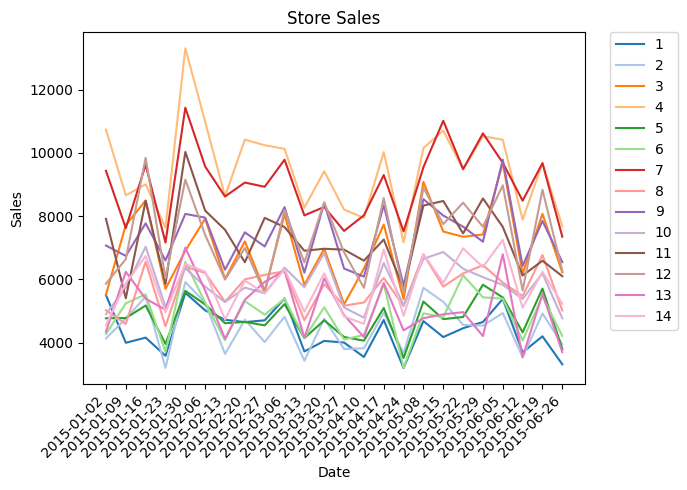

In [4]:
store_counts = len(subset['Store'].unique())
palette = sns.color_palette("tab20", store_counts)

fig, ax = plt.subplots(figsize=(7, 5))
sns.lineplot(data=subset, x='Date', y='Sales', hue='Store', palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.title('Store Sales')
plt.tight_layout()
plt.show()

## Generate Synthetic Group

1. Control group (n = 8): No treatment <br>
2. Treatment group (n = 6): Advertizement <br>

Assume the treatment started on 2015-04-17.
To generate synthetic treatment effect on sales, increase sales in the treatment group by up to 40%.

In [5]:
# make synthetic treatment group
treatmt_stores = np.random.choice(subset['Store'].unique(), 6)
subset.loc[:,'Group'] = np.where(subset['Store'].isin(treatmt_stores), 1, 0) # 0: control, 1: treatment
subset.loc[:,'pre_post_treatmt'] = np.where(subset['Date'] < '2015-04-17', 0, 1) # 0: pre-treatment, 1: post-treatmt
subset.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Group,pre_post_treatmt
234163,14,5,2015-01-02,4555,605,1,0,0,1,0,0
234162,13,5,2015-01-02,4348,346,1,0,0,1,0,0
234161,12,5,2015-01-02,5866,723,1,0,0,1,0,0
234160,11,5,2015-01-02,7915,1214,1,0,0,1,1,0
234159,10,5,2015-01-02,4902,514,1,0,0,1,0,0


In [6]:
subset[(subset['Group'] == 'treatment')
        & (subset['Date'] > '2015-04-17')].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Group,pre_post_treatmt


In [7]:
# make synthetic effect on sales. randomly add up to 30% increased in sales
for index, row in subset.iterrows():
    if (row['Group'] == 1) & (row['Date'] > '2015-04-17'):
        subset.at[index, 'Sales'] = row['Sales'] * round(random.uniform(1.05, 1.4), 2)
    else:
        subset.at[index, 'Sales'] = row['Sales']

# supress sales for store 4, 7 , & 11 in the pretreatment period to make sales in pretreatment period insignificant
# 28% reduction of sales
for index, row in subset.iterrows():
    if (row['Store'] in [4,7,11,12]) & (row['Date'] < '2015-04-17'):
        subset.at[index, 'Sales'] = row['Sales'] * 0.72
    else:
        subset.at[index, 'Sales'] = row['Sales']

/tmp/ipykernel_572/1962886688.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7592.97' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subset.at[index, 'Sales'] = row['Sales'] * round(random.uniform(1.05, 1.4), 2)


## Visualize after adding synthetic effect on sales

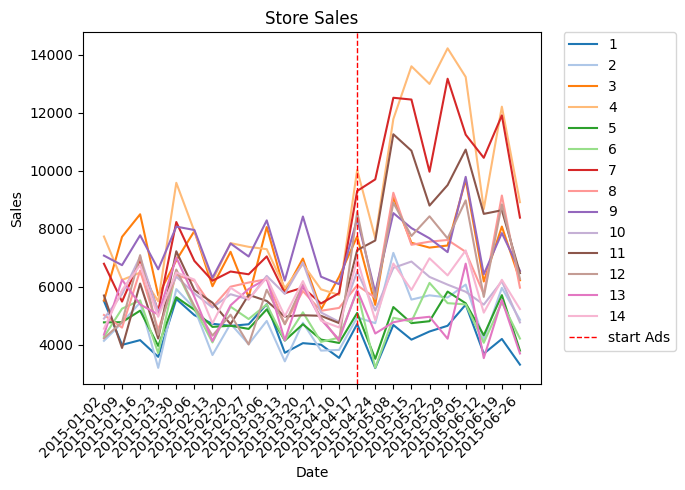

In [8]:
store_counts = len(subset['Store'].unique())
palette = sns.color_palette("tab20", store_counts)

fig, ax = plt.subplots(figsize=(7, 5))
sns.lineplot(data=subset, x='Date', y='Sales', hue='Store', palette=palette, ax=ax)
plt.axvline('2015-04-17',color='red', linestyle='dashed', linewidth=1, label='start Ads')

plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.title('Store Sales')
plt.tight_layout()
plt.show()

In [9]:
# Calculating averages and standard errors
ab_means = (subset
 .groupby(['Group', 'pre_post_treatmt'])
 .agg({'Sales':['mean', 'std']})
 .round(2)
 )
ab_means

Sales         
                           mean      std
Group pre_post_treatmt                  
0     0                 5514.02  1167.89
      1                 5980.71  1586.87
1     0                 5697.05  1200.58
      1                 8764.02  2717.68

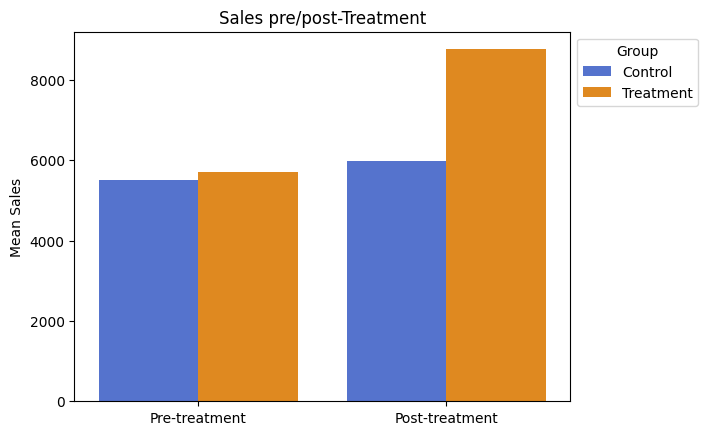

In [81]:
ab_means_copy = ab_means.copy()
ab_means_copy = ab_means_copy.reset_index()

ax = sns.barplot(data=ab_means_copy, x='pre_post_treatmt', y=('Sales','mean'), hue='Group', palette=['royalblue','darkorange'])
plt.title('Sales pre/post-Treatment')
plt.ylabel('Mean Sales')
plt.xticks([0,1],['Pre-treatment','Post-treatment'])
plt.xlabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Control', 'Treatment'], title='Group', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

### Pre-treatment Period

In [10]:
t_stat, p_val = stats.ttest_ind(subset[(subset['Group']==0)
                                 & (subset['pre_post_treatmt']==0)]['Sales'],
                                subset[(subset['Group']==1)
                                 & (subset['pre_post_treatmt']==0)]['Sales'])

if p_val < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Fail to reject the null hypothesis


Before intervention (prior to 2015-04-17), mean of sales in the treatment group is equivalent to that in the control group

## Difference-in-Difference Analysis

In [11]:
import statsmodels.formula.api as smf

In [12]:
subset['did'] = subset['Group'] * subset['pre_post_treatmt']

# Fit the DiD model
model = smf.ols(formula='Sales ~ Group + pre_post_treatmt + did', data=subset).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     52.95
Date:                Wed, 25 Dec 2024   Prob (F-statistic):           5.42e-28
Time:                        22:39:22   Log-Likelihood:                -2954.9
No. Observations:                 336   AIC:                             5918.
Df Residuals:                     332   BIC:                             5933.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5514.0219    143.046  

Based on the result, 
* Significant pre_post_treatment indicates after the intervention day, overall sales are increased in both group.
* Significant interaction term 'did' shows a substantial increase in sales specifically for the treatment group following the intervention,

In conclusion, the intervension effectively increase the sale by ~2622 units.

## Visualize Control and Treatment Group Distribution

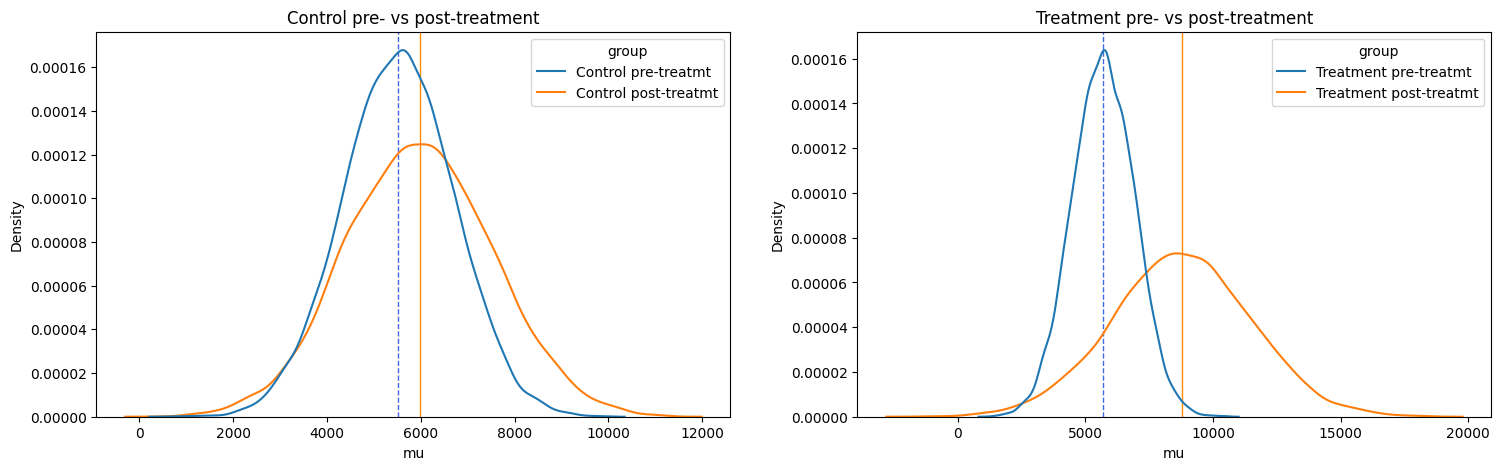

In [13]:
plt.figure(figsize=(18, 5))

# Control Samples
# Creating Normal Distribution of both Control samples
size = 10000
plt.subplot(1, 2, 1)
plot_a = np.random.normal(loc= ab_means.iloc[0,0], scale= ab_means.iloc[0,1], size=size)
plot_b = np.random.normal(loc= ab_means.iloc[1,0], scale= ab_means.iloc[1,1], size=size)

plot = pd.DataFrame({'group': ['Control pre-treatmt']*size + ['Control post-treatmt']*size,
                     'mu': np.concatenate([plot_a, plot_b])})
# Intervention date line
plt.axvline(x=ab_means.iloc[0,0], color="royalblue", linestyle="--", lw=1)
plt.axvline(x=ab_means.iloc[1,0], color="darkorange", lw=1)
sns.kdeplot(plot, x='mu', hue='group')
plt.title('Control pre- vs post-treatment');

plt.subplot(1, 2, 2)
# Treatment Samples
# Creating Normal Distribution of both Treatment samples
plot_a = np.random.normal(loc= ab_means.iloc[2,0], scale= ab_means.iloc[2,1], size=size)
plot_b = np.random.normal(loc= ab_means.iloc[3,0], scale= ab_means.iloc[3,1], size=size)

plot = pd.DataFrame({'group': ['Treatment pre-treatmt']*size + ['Treatment post-treatmt']*size,
                     'mu': np.concatenate([plot_a, plot_b])})
# Intervention date line
plt.axvline(x=ab_means.iloc[2,0], color="royalblue", linestyle="--", lw=1)
plt.axvline(x=ab_means.iloc[3,0], color="darkorange", lw=1)
sns.kdeplot(plot, x='mu', hue='group')
plt.title('Treatment pre- vs post-treatment');